
# Parameter Sweeps

In this tutorial, you will learn how to use the :code:`pyrates.grid_search()` function, which allows you to
perform simulations of multiple parametrizations of a model in parallel. You will learn in which ways you can specify
your parameter grid, how you can customize your simulation settings and how to handle the output of the
:code:`grid_search()` function.
As an example, we will use the Jansen-Rit model (check out the model introduction for the Jansen-Rit model, to learn
about the mathematics behind the model and about its implementation in PyRates) [1]_.
We will perform a 1D parameter sweep over its connectivity scaling parameter $C$.

**References**

.. [1] B.H. Jansen & V.G. Rit (1995) *Electroencephalogram and visual evoked potential generation in a mathematical
       model of coupled cortical columns.* Biological Cybernetics, 73(4): 357-366.


First, let's import the :code:`grid_search()` function from PyRates as well as some additional packages



In [7]:
from pyrates import grid_search
import matplotlib.pyplot as plt
import numpy as np

## Step 1: Identify a parameter to sweep over

The Jansen-Rit model consists of 3 populations: Pyramidal cells (PCs), excitatory interneurons (EINs), and inhibitory
interneurons (IINs). Between those populations, there exist 4 synaptic connections: PC to EIN, PC to IIN, EIN to PC,
and IIN to PC. They are all scaled by a single base connectivity strength $C$. We will now perform a parameter
sweep over this parameter, i.e. examine the Jansen-Rit model behavior for a number of different values of this general
synaptic strength scaling. This parameter sweep has also been performed in the original publication in which Jansen
and Rit introduced their model. Check out [1]_ to compare the results of this parameter sweep with the published
results.



## Step 2: Specify the parameter grid

To perform a parameter sweep, we first define a range of values for C:



In [8]:
param_grid = {'C': [68., 128., 135., 270., 675., 1350.]}

As can be seen, parameter grids are defined as dictionaries, where each parameter that should be changed during the
sweep receives a separate key, with the sweep values following as a list or numpy array afterwards.
Furthermore, we need to define over which model parameter to perform the sweep. This is done via a parameter map that
maps each key in the parameter grid to a certain variable in the model:



In [9]:
param_map = {'C': {'vars': ['jrc_op/c'], 'nodes': ['jrc']}}

For each parameter in the sweep, you can define multiple variables that should take on the values of this parameter.
These variables can even be placed in different nodes in the network. Simply provide the names of all nodes as a list
under the key :code:`nodes` and the operator and variable names as a list under the key :code:`vars`,
following the format :code:`op_name/var_name`.

These are the basic ingredients that are required by the :code:`grid_search()` function in addition to the standard
arguments that are needed for the model initialization and simulation. The latter arguments are explained in detail
in the documentation of the :code:`pyrates.frontend.CircuitTemplate.run()` method as well as in the example gallery
for numerical simulations.



## Step 3: Perform the parameter sweep

To perform the parameter sweep, execute the following call to the :code:`grid_search()` function:



In [10]:
# define simulation parameters
T = 10.0
dt = 1e-4
dts = 1e-3
cutoff = 1.0
noise = np.random.uniform(120.0, 320.0, size=(int(np.round(T/dt, decimals=0)), 1))

# perform parameter sweep
results, results_map = grid_search(circuit_template="model_templates.neural_mass_models.jansenrit.JRC2",
                                   param_grid=param_grid,
                                   param_map=param_map,
                                   simulation_time=T,
                                   step_size=dt,
                                   sampling_step_size=dts,
                                   inputs={'jrc/jrc_op/u': noise},
                                   outputs={'V_pce': 'jrc/jrc_op/V_e', 'V_pci': 'jrc/jrc_op/V_i'},
                                   backend="default",
                                   solver="euler",
                                   cutoff=cutoff
                                   )

Compilation Progress
--------------------
	(1) Translating the circuit template into a networkx graph representation...
		...finished.
	(2) Preprocessing edge transmission operations...
		...finished.
	(3) Parsing the model equations into a compute graph...
		...finished.
	Model compilation was finished.
Simulation Progress
-------------------
	 (1) Generating the network run function...
	 (2) Processing output variables...
		...finished.
	 (3) Running the simulation...


/storage/ice1/1/9/mchen439/MATH8803-Final-Project/pyrates_run.py:7: RuntimeWarning: overflow encountered in exp
  return 1./(1. + exp(-x))


After performing the parameter sweep, :code:`grid_search()` returns a tuple with 2 entries
  - a 2D :code:`pandas.DataFrame` that contains the simulated timeseries (rows) for each output variable for
    each model parametrization (columns)
  - a 2D :code:`pandas.DataFrame` that contains a mapping between the column names of the timeseries in the first
    tuple entry (columns) and the parameter values of the parameters that were defined in the parameter grid
    (rows).

Now, lets visualize the results of this parameter sweep for each value of $C$:



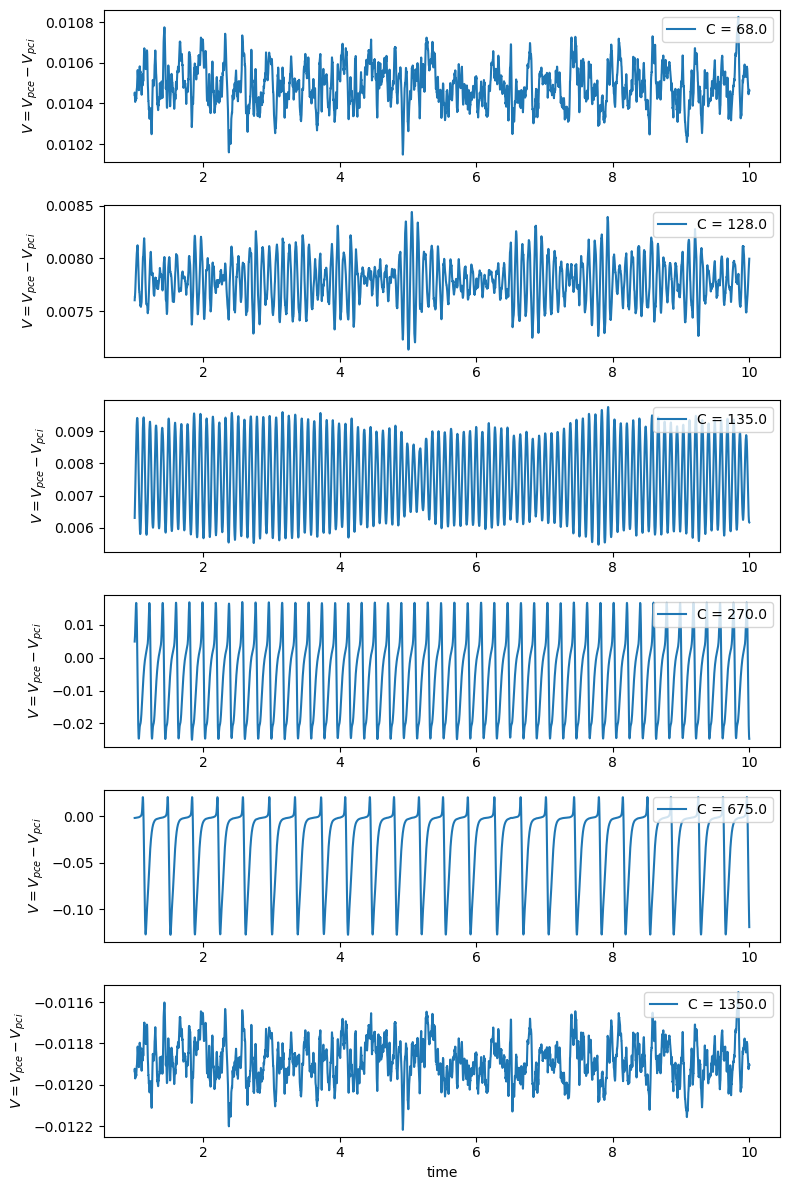

In [ ]:
fig, axes = plt.subplots(nrows=results_map.shape[0], figsize=(8, 12))

# sort the results map via the values of C
results_map.sort_values('C', inplace=True, axis=0)

# plot the raw output variable for each condition
for ax, key in zip(axes, results_map.index):
    psp_e = results['V_pce'][key].iloc[:, 0]
    psp_i = results['V_pci'][key].iloc[:, 0]
    ax.plot(psp_e - psp_i)
    ax.legend([f"C = {results_map.at[key, 'C']}"], loc='upper right')
    ax.set_ylabel(r'$V = V_{pce} - V_{pci}$')
axes[-1].set_xlabel('time')
plt.tight_layout()
plt.show()

Note that, since the parameter values are arranged in a :code:`pandas.DataFrame`, sorting their values is very
straight forward. For each value of $C$ in ascending order, we extract the name of the respective columns in
:code:`results` to receive our 2 stored output variables. The difference between those two state variables resembles
the average membrane potential of the PC population of the Jansen-Rit model. This is what we plot for each condition.
You will find that the resulting time series resemble those reported by Jansen and Rit in [1]_.

